<a href="https://colab.research.google.com/github/9keshu/Depression-Analysis/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# !pip install tensorflow-addons

In [ ]:

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

# import psutil
# import humanize
# import os, time
# import GPUtil as GPU

print(tf.__version__)

2.4.1


In [ ]:
# GPUs = GPU.getGPUs()
# # only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def worker():
#   while True:
#     process = psutil.Process(os.getpid())
#     print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
#     time.sleep(6)

# import threading
# t = threading.Thread(target=worker, name='Monitor')
# t.start()

In [ ]:
# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:

data_df = pd.read_csv("trainCSV.csv")

In [ ]:
data_df = data_df.dropna(axis=0)

In [ ]:
data_df.shape

(5000, 3)

In [ ]:

data_df['tweet'] = data_df['tweet'].str.replace('\n', ' ').str.strip()

In [ ]:
data_df

,id,tweet,label
0,1.0,Feeling a bit depressedI've been in a big low ...,depression
1,2.0,Was going to hang myself but didn't have guts ...,depression
2,3.0,Have you ever maintained a poor friendship jus...,depression
3,4.0,I haven't felt positive feelings in a long tim...,depression
4,5.0,Partners of those who suffer from depression; ...,depression
...,...,...,...
4995,4996.0,I've been playing soccer since I was 4. I was ...,Non-Depressed
4996,4997.0,My husband and I just spent 5 days in Nice and...,Non-Depressed
4997,4998.0,"Hey all, as the title says I'm new to DNM. I a...",Non-Depressed
4998,4999.0,Looking for a fantasy or sci fi novel with a g...,Non-Depressed


In [ ]:
labels = ['depression','Non-Depressed']
def label_encode(val):
    return labels.index(val)

In [ ]:
data_df.label = data_df.label.apply(label_encode)

In [ ]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(data_df['tweet'], data_df['label'], test_size=0.20, random_state=42)

In [ ]:
train_y.value_counts(), valid_y.value_counts()

(1    2000
 0    2000
 Name: label, dtype: int64, 1    500
 0    500
 Name: label, dtype: int64)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x.values, train_y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_x.values, valid_y.values))

In [ ]:
for feat, targ in train_dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b"I'm a full time college student, and continue to ride on the side. I have been getting lessons while at school, but I'm getting so much more comfortable in the 2'6-3' range and am getting ready to continue moving up. The issue is, most lesson horses (at least in my area) top out around 3', if that. If I want to continue to move up, I need to figure out a different situation. The issue is, being a college student, I can't afford a huge amount. Here are some options I've thought of:1. Look for leases nearby. The issue is, most good horses are expensive even as a lease, plus board on top of that! The positive is it's relatively non-committal (I don't own the horse, therefore I won't have to worry about selling it and stuff down the road). 2. Buy an OTTB or younger horse, with plenty of potential. This seems to be the most unrealistic, as it requires more money up front, and that's the cheap part, with all of those additional expenses, unless I share-boarded.3. Hope an ideal si

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I'm trying so hard to forget him. He seems to be everywhere. I'm already over the breakup. I know it was for the best. I wanted too many things, expected too much and that's why I let him go. It wasn't fair to him and he knew it too. Today at work a mutual friend of his mom saw me and said that his mom had said she said hi and that she missed me. I smiled and told her to tell her I missed her too. It's little stuff like this that makes him pop into my mind. I just want to forget him and us. 6 years wasted. Then today I got asked out by another guy who I am talking to on Facebook and declined. I'm just not ready or enthusiastic about relationships anymore. The romantic dream of getting married and having a happily ever after is dead now. Ugh. Break ups suck."
 b'Anyone has similar issue?I was running 20170328 and verything was good.Upgraded to latest nightly using twrp and now all sounds are gone.BTW: what is the proper way of upgrading between releases? Do i need to wipe any

In [ ]:

VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'and', 'the', 'a', 'my', 'of', 'it',
       'that', 'in', 'is', 'me', 'for', 'but', 'have', 'im', 'this',
       'with'], dtype='<U13')

In [ ]:
encoded_example = encoder(train_x.to_list()[1])[:3].numpy()
encoded_example

array([  1, 139,  10])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5 )])

In [ ]:

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
63/63 [==============================] - 153s 2s/step - loss: 0.6909 - accuracy: 0.5191 - f1_score: 0.0000e+00 - val_loss: 0.6785 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00
Epoch 2/10
63/63 [==============================] - 133s 2s/step - loss: 0.6389 - accuracy: 0.5515 - f1_score: 0.1600
Epoch 3/10
63/63 [==============================] - 130s 2s/step - loss: 0.3412 - accuracy: 0.8849 - f1_score: 0.8753
Epoch 4/10
63/63 [==============================] - 132s 2s/step - loss: 0.2849 - accuracy: 0.8983 - f1_score: 0.8915
Epoch 5/10
63/63 [==============================] - 133s 2s/step - loss: 0.2447 - accuracy: 0.9194 - f1_score: 0.9160
Epoch 6/10
63/63 [==============================] - 127s 2s/step - loss: 0.2565 - accuracy: 0.9197 - f1_score: 0.9157
Epoch 7/10
63/63 [==============================] - 129s 2s/step - loss: 0.2196 - accuracy: 0.9334 - f1_score: 0.9311
Epoch 8/10
63/63 [==============================] - 127s 2s/step - loss: 0.2102 - accuracy: 0.9295 - 

In [ ]:
test_loss, test_acc, test_f1_score = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

16/16 [==============================] - 8s 476ms/step - loss: 0.2645 - accuracy: 0.9140 - f1_score: 0.9138
Test Loss: 0.264512300491333
Test Accuracy: 0.9139999747276306


(0.0, 0.7124112270772457)

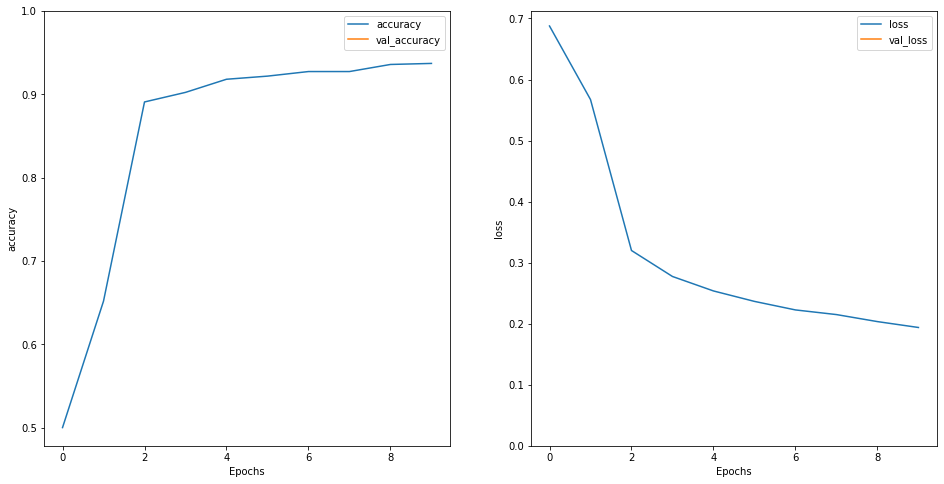

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
#saving a model in HDF5 format
#model is a tf.keras.Model object created using any of the above methods
model.save("/content/drive/My Drive/Colab_Notebooks/rnn_lstm_v1.tf", save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm_v1.tf/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm_v1.tf/assets


In [ ]:
history = model.fit(train_dataset, epochs=6,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/6
63/63 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9425 - f1_score: 0.9421WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


63/63 [==============================] - 141s 2s/step - loss: 0.2000 - accuracy: 0.9425 - f1_score: 0.9421 - val_loss: 0.2364 - val_accuracy: 0.9250 - val_f1_score: 0.9249
Epoch 2/6
63/63 [==============================] - 134s 2s/step - loss: 0.1864 - accuracy: 0.9473 - f1_score: 0.9473
Epoch 3/6
63/63 [==============================] - 130s 2s/step - loss: 0.1674 - accuracy: 0.9548 - f1_score: 0.9545
Epoch 4/6
63/63 [==============================] - 132s 2s/step - loss: 0.1581 - accuracy: 0.9565 - f1_score: 0.9562
Epoch 5/6
63/63 [==============================] - 127s 2s/step - loss: 0.1615 - accuracy: 0.9528 - f1_score: 0.9526
Epoch 6/6
63/63 [==============================] - 137s 2s/step - loss: 0.1394 - accuracy: 0.9607 - f1_score: 0.9603


In [ ]:
test_loss, test_acc, test_f1_score = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

16/16 [==============================] - 8s 483ms/step - loss: 0.2136 - accuracy: 0.9280 - f1_score: 0.9283
Test Loss: 0.21359297633171082
Test Accuracy: 0.9279999732971191


(0.0, 0.24127603694796562)

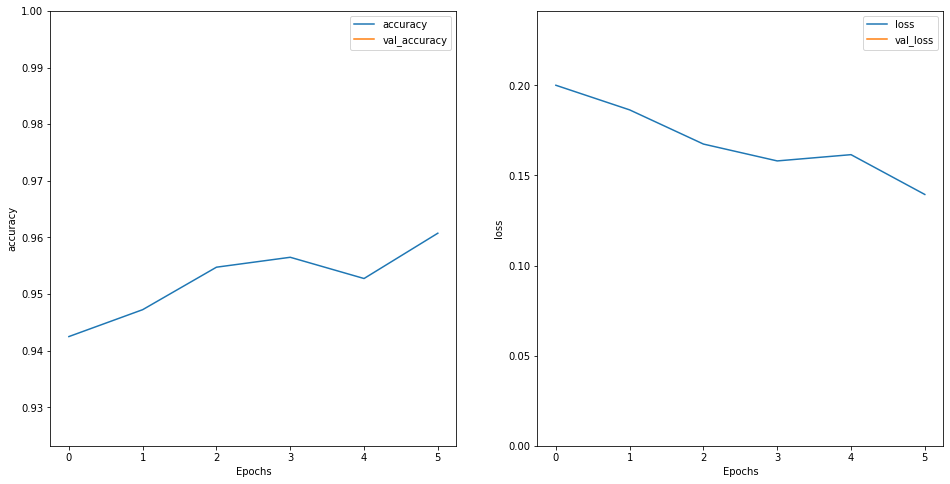

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5 )])

In [ ]:

history2 = model2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5123 - f1_score: 0.0000e+00WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


63/63 [==============================] - 282s 4s/step - loss: 0.6896 - accuracy: 0.5121 - f1_score: 0.0000e+00 - val_loss: 0.6706 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00
Epoch 2/10
63/63 [==============================] - 254s 4s/step - loss: 0.6211 - accuracy: 0.5814 - f1_score: 0.2597
Epoch 3/10
63/63 [==============================] - 246s 4s/step - loss: 0.3702 - accuracy: 0.8580 - f1_score: 0.8427
Epoch 4/10
63/63 [==============================] - 250s 4s/step - loss: 0.2811 - accuracy: 0.9069 - f1_score: 0.9057
Epoch 5/10
63/63 [==============================] - 245s 4s/step - loss: 0.2401 - accuracy: 0.9135 - f1_score: 0.9123
Epoch 6/10
63/63 [==============================] - 248s 4s/step - loss: 0.2179 - accuracy: 0.9244 - f1_score: 0.9223
Epoch 7/10
63/63 [==============================] - 247s 4s/step - loss: 0.1944 - accuracy: 0.9305 - f1_score: 0.9266
Epoch 8/10
63/63 [==============================] - 236s 4s/step - loss: 0.1688 - accuracy: 0.9420 - f1_score: 0

In [ ]:
test_loss, test_acc, test_f1_score = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

16/16 [==============================] - 15s 935ms/step - loss: 0.1905 - accuracy: 0.9370 - f1_score: 0.9362
Test Loss: 0.19049440324306488
Test Accuracy: 0.9369999766349792


(0.0, 0.7128876321017742)

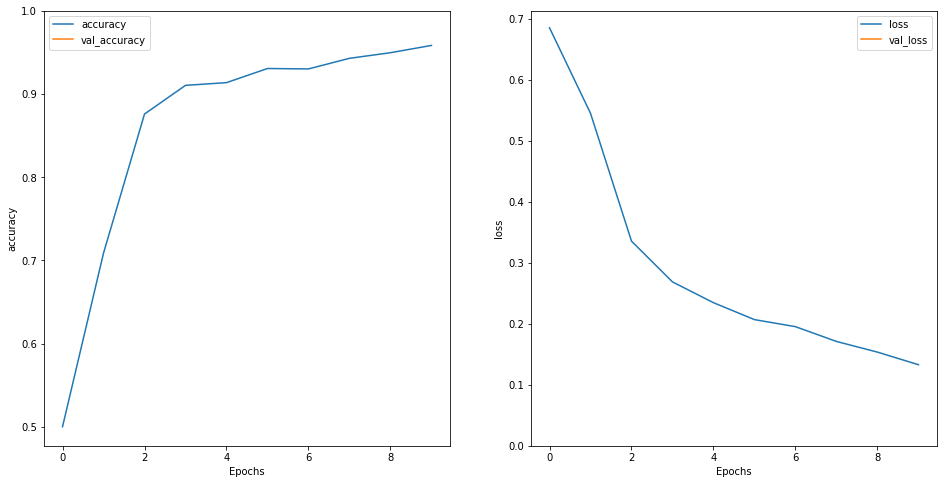

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history2, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history2, 'loss')
plt.ylim(0,None)

In [ ]:
#saving a model in HDF5 format
#model is a tf.keras.Model object created using any of the above methods
model.save("/content/drive/My Drive/Colab_Notebooks/rnn_lstm2_v1.tf", save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm2_v1.tf/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm2_v1.tf/assets
